###**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

###**Data Loading and Overview**

In [3]:
df=pd.read_csv("complaints.csv")
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [4]:
df.shape

(162421, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


###**Data Preprocessing**

####**Data Cleaning**

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.rename(columns={'unnamed:_0': 'complaint_no', 'narrative': 'complaints'})

In [7]:
df.head()

,complaint_no,product,complaints
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [8]:
print("Missing values:\n")
df.isnull().sum()

Missing values:



complaint_no     0
product          0
complaints      10
dtype: int64

In [9]:
df = df.dropna()

In [10]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


In [11]:
df.shape

(162411, 3)

#### **Exploratory Data Analysis**

In [12]:
print("Unique Products:", df["product"].unique())

Unique Products: ['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']


In [13]:
product_counts = df['product'].value_counts()
display(product_counts)

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

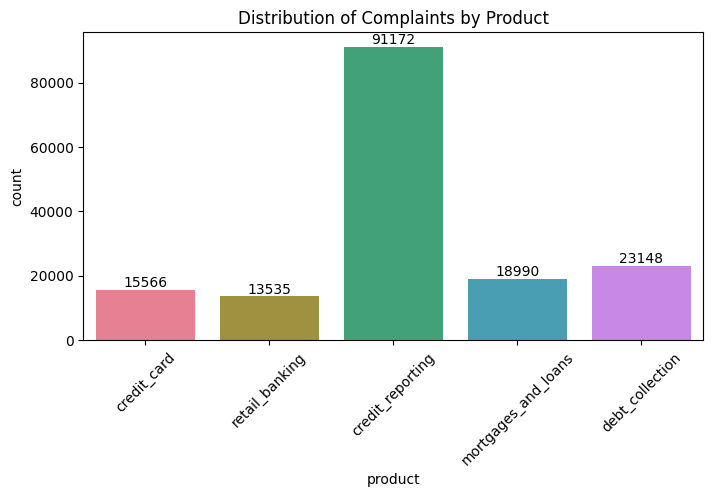

In [14]:
#Plot product distribution
plt.figure(figsize=(8,4))
p = sns.countplot(x='product', data=df,hue='product', palette='husl')
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=45)

for bars in p.containers:
    p.bar_label(bars, fmt='%d')

plt.show()


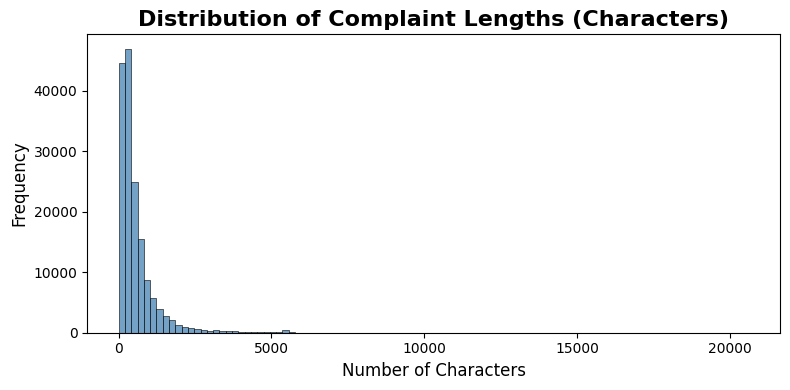

In [15]:
# Calculate complaint length
df['complaint_length'] = df['complaints'].astype(str).str.len()
# Visualize complaint length distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['complaint_length'], bins=100, color='steelblue')
plt.title('Distribution of Complaint Lengths (Characters)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
print("Statistics:")
print(f"Average complaint length: {df['complaint_length'].mean():.0f} characters")
print(f"Median complaint length: {df['complaint_length'].median():.0f} characters")
print(f"Shortest complaint: {df['complaint_length'].min():.0f} characters")
print(f"Longest complaint: {df['complaint_length'].max():.0f} characters")

Statistics:
Average complaint length: 589 characters
Median complaint length: 361 characters
Shortest complaint: 3 characters
Longest complaint: 20596 characters


#### **Text Preprocessing**

In [17]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Convert to lowercase and handle NaN
    if pd.isna(text) or not str(text).strip():
        return ''
    text = str(text).lower().strip()

    # 2. Remove URLs, emails, special characters, digits, and extra whitespaces
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)                   # Remove email addresses
    text = re.sub(r'[^a-z\s]', '', text)                  # Keep only alphabets and spaces
    text = re.sub(r'\s+', ' ', text).strip()              # Remove extra spaces

    # 3. Tokenize
    words = word_tokenize(text)

    # 4. Remove stopwords
    words = [w for w in words if w not in stop_words]

    # 5. Lemmatize (as verbs)
    words = [lemmatizer.lemmatize(w, pos='v') for w in words]

    # 6. Remove very short words (<=2 letters)
    words = [w for w in words if len(w) > 2]

    # 7. Join tokens back into a cleaned sentence
    return ' '.join(words)


In [18]:
df['cleaned_complaints'] = df['complaints'].apply(clean_text)
df[['complaints', 'cleaned_complaints']].head()

,complaints,cleaned_complaints
0,purchase order day shipping amount receive pro...,purchase order day ship amount receive product...
1,forwarded message date tue subject please inve...,forward message date tue subject please invest...
2,forwarded message cc sent friday pdt subject f...,forward message send friday pdt subject final ...
3,payment history missing credit report speciali...,payment history miss credit report specialize ...
4,payment history missing credit report made mis...,payment history miss credit report make mistak...


####**Label Encoding**

In [19]:
# Encode categorical target (product)
le = LabelEncoder()
df['product_encoded'] = le.fit_transform(df['product'])

In [20]:
df = df.drop(['complaint_no', 'complaints', 'complaint_length'], axis=1)

In [21]:
df.head()

,product,cleaned_complaints,product_encoded
0,credit_card,purchase order day ship amount receive product...,0
1,credit_card,forward message date tue subject please invest...,0
2,retail_banking,forward message send friday pdt subject final ...,4
3,credit_reporting,payment history miss credit report specialize ...,1
4,credit_reporting,payment history miss credit report make mistak...,1


###**Model Implementation and Training**

In [22]:
# Define features and labels
X = df['cleaned_complaints']
y = df['product_encoded']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"Number of features (vocabulary size): {len(tfidf.vocabulary_)}")


Training features shape: (129928, 10000)
Testing features shape: (32483, 10000)
Number of features (vocabulary size): 10000


Before SMOTE: [12453 72937 18518 15192 10828]
After SMOTE: [72937 72937 72937 72937 72937]


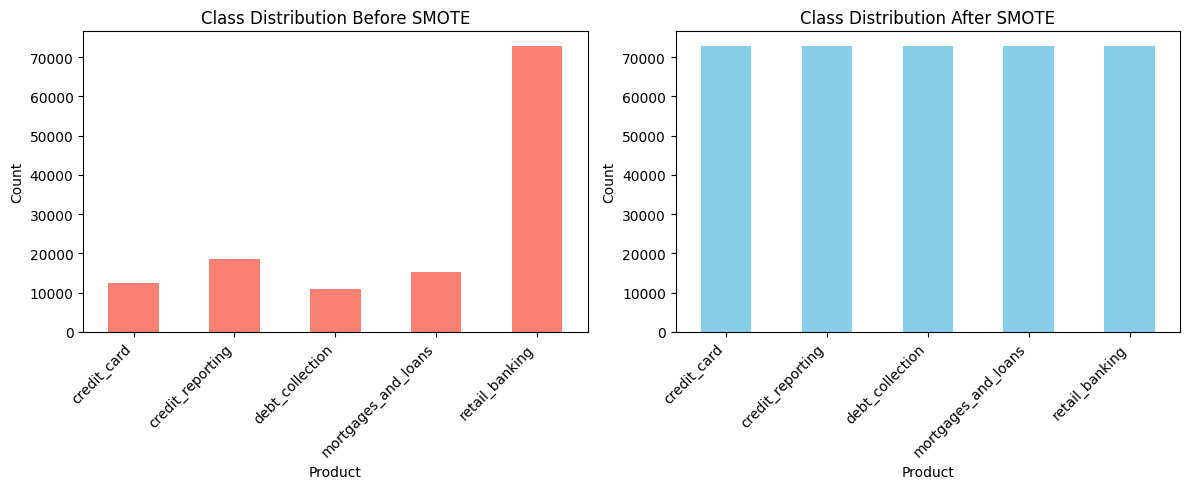

In [25]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Print class counts before and after
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

# Convert y labels to pandas Series with product names
before = pd.Series(y_train).map(dict(enumerate(df['product'].unique()))).value_counts().sort_index()
after = pd.Series(y_train_resampled).map(dict(enumerate(df['product'].unique()))).value_counts().sort_index()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
before.plot(kind='bar', color='salmon')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
after.plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [26]:
print("MODEL 1: LOGISTIC REGRESSION")
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_log))

MODEL 1: LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3113
           1       0.95      0.87      0.91     18235
           2       0.72      0.84      0.77      4630
           3       0.79      0.86      0.83      3798
           4       0.85      0.89      0.87      2707

    accuracy                           0.86     32483
   macro avg       0.81      0.86      0.83     32483
weighted avg       0.87      0.86      0.86     32483



In [27]:
print("MODEL 2: SUPPORT VECTOR MACHINE (SVM)")
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))

MODEL 2: SUPPORT VECTOR MACHINE (SVM)
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      3113
           1       0.95      0.87      0.91     18235
           2       0.71      0.83      0.77      4630
           3       0.79      0.84      0.81      3798
           4       0.83      0.86      0.85      2707

    accuracy                           0.85     32483
   macro avg       0.80      0.84      0.82     32483
weighted avg       0.86      0.85      0.86     32483



###**Model Comparison and Evaluation**

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8615,0.8717,0.8615,0.8644
1,Support Vector Machine,0.8545,0.8648,0.8545,0.8576


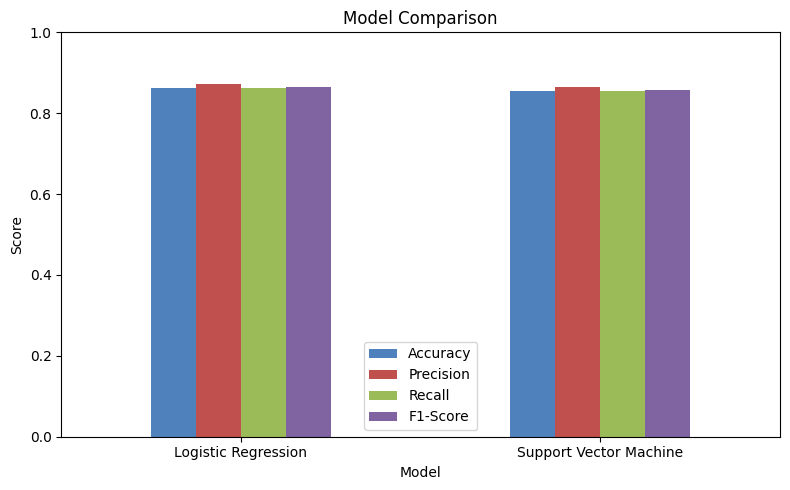

In [28]:
from sklearn.metrics import classification_report

# Compare metrics using classification report
models = {     
    'Logistic Regression': y_pred_log,     
    'Support Vector Machine': y_pred_svm 
}

results = []
for m, pred in models.items():
    report = classification_report(y_test, pred, output_dict=True)
    # Extract overall accuracy, precision, recall, and f1-score
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    results.append([m, accuracy, precision, recall, f1])


df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
display(df.round(4))

# Plot
df.set_index('Model').plot(kind='bar', figsize=(8,5), color = ['#4F81BD', '#C0504D', '#9BBB59', '#8064A2']
)
plt.title('Model Comparison')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
#Making predictions using the best model
def predict(model, text):
    clean = clean_text(text)
    vec = tfidf.transform([clean])
    pred = model.predict(vec)
    label = le.inverse_transform(pred)[0]
    return label


samples = [
    "I was charged an annual fee on my credit card even though the bank representative assured me it was a lifetime free card. Customer support has been ignoring my emails for weeks.",
    "My mortgage payment was deducted twice from my account this month, and despite multiple calls, the refund hasn’t been processed yet."
]

print("Logistic Regression Model Predictions")
for s in samples:
    print(f"Complaint: {s}\nPredicted Category: {predict(log_model, s)}\n")

Logistic Regression Model Predictions
Complaint: I was charged an annual fee on my credit card even though the bank representative assured me it was a lifetime free card. Customer support has been ignoring my emails for weeks.
Predicted Category: credit_card

Complaint: My mortgage payment was deducted twice from my account this month, and despite multiple calls, the refund hasn’t been processed yet.
Predicted Category: mortgages_and_loans



In [32]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer_D1.pkl")
joblib.dump(le, "label_encoder_D1.pkl")
joblib.dump(log_model, "logistic_model_D1.pkl")
joblib.dump(svm_model, "svm_model_D1.pkl")
print("All model and preprocessing files saved successfully!")


All model and preprocessing files saved successfully!
